# pyod包简介

## 注意事项
1. 当使用包含神经网络进行训练的函数时，需要安装keras或者tensorflow  
2. 在MAC端的anaconda环境中使用matplotlib可能会出现错误
3. 部分算法与sklearn中的功能相同，推荐尽量使用一种即可

## 函数的通用使用方法  
- 模型训练  
    - fit(x)训练模型
    - decision_function(x) 返回数据训练数据的异常程度得分
    - predict(x)预测是否为异常值（异常=1）
    - predict_proba(x)预测是异常值的概率
- 模型属性
    - decision_scores 异常值的得分
    - labels_ 训练的异常标签

## 模型保存 
推荐使用joblib 或者pickle  

1. joblib的使用方法  
```python
    from joblib import dump, load
    # save the model
    dump(clf, 'clf.joblib')
    # load the model
    clf = load('clf.joblib')
```  
2. pickle  
```python
    #保存
    pickle.dump(需要保存的对象,
           open(os.path.join(文件夹地址,'文件名'),'wb'),
           protocol=4)
    #加载
    pickle.load(open(文件路径),'rb'))
```

## 三个函数组
1. 单独异常检测算法
    -比如PCA，LOF等
2. 集成或结合的异常检测算法  
    -比如LSCP，LODA  
3. 其他多用途的函数  
    -generate_data，generate_data_clusters

## 17个模型在基准数据上的表现   
在选择使用哪个模型时，可以先判断数据集跟哪个基准数据的类别相同，然后选取几个模型进行综合比较  
链接：
[Benchmark](https://pyod.readthedocs.io/en/latest/benchmark.html)

## 多个基准检测器的结合  
由于现实预测中的各种变化，导致单一检测模型的鲁棒性较差，因此通常是用多个检测器，将结果进行综合，来提高预测结果的稳定性  
1. 平均处理  
2. 取最大值  
3. 取最大值的平均  
4. 取平均值的最大值  
代码示例：[comb.py](https://github.com/yzhao062/pyod/blob/master/examples/comb_example.py)

# 异常值检测示例  
> 参考博客文章：[An Awesome Tutorial to Learn Outlier Detection in Python using PyOD Library](https://www.analyticsvidhya.com/blog/2019/02/outlier-detection-python-pyod/)

## Angle-Based Outlier Detection (ABOD)介绍  


## KNN 介绍

## 导入数据包，生成模拟数据

In [4]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.font_manager

from pyod.models.abod import ABOD
from pyod.models.knn import KNN

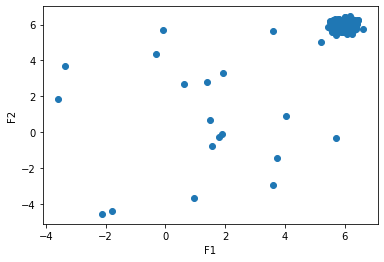

In [5]:
from pyod.utils.data import generate_data,get_outliers_inliers

# 生成二维随机数据
X_train, Y_train = generate_data(n_train=200,train_only=True, n_features=2)

# 拆分出异常数据和正常数据
x_outliers, x_inliers = get_outliers_inliers(X_train,Y_train)

# 绘制生成的数据图
F1 = X_train[:,[0]].reshape(-1,1)
F2 = X_train[:,[1]].reshape(-1,1)
plt.scatter(F1,F2)
plt.xlabel('F1')
plt.ylabel('F2') 
plt.show()

## 使用两个模型进行训练

No of Errors :  Angle-based Outlier Detector (ABOD) 3
No of Errors :  K Nearest Neighbors (KNN) 0


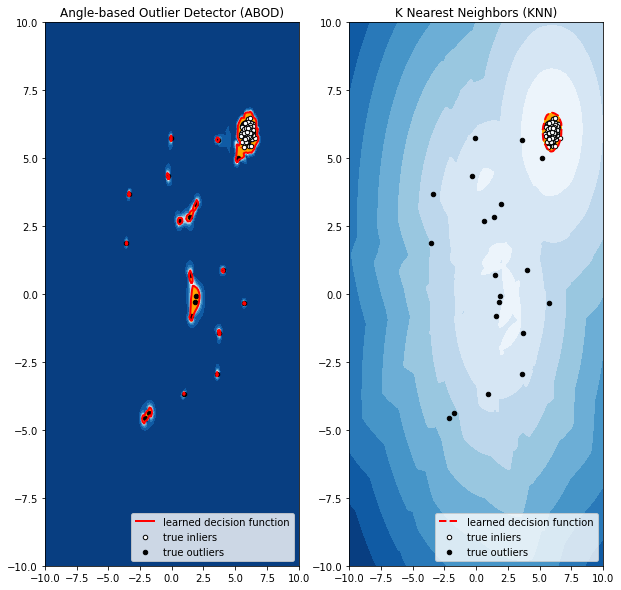

In [6]:
outlier_fraction = 0.1
n_inliers = len(x_inliers)
n_outliers = len(x_outliers)
xx , yy = np.meshgrid(np.linspace(-10, 10, 200), np.linspace(-10, 10, 200))

classifiers = {
     'Angle-based Outlier Detector (ABOD)'   : ABOD(contamination=outlier_fraction),
     'K Nearest Neighbors (KNN)' :  KNN(contamination=outlier_fraction)
}

plt.figure(figsize=(10, 10))

for i, (clf_name,clf) in enumerate(classifiers.items()) :
    # fit the dataset to the model
    clf.fit(X_train)

    # predict raw anomaly score
    scores_pred = clf.decision_function(X_train)*-1

    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X_train)

    # no of errors in prediction
    n_errors = (y_pred != Y_train).sum()
    print('No of Errors : ',clf_name, n_errors)

    # rest of the code is to create the visualization

    # threshold value to consider a datapoint inlier or outlier
    threshold = stats.scoreatpercentile(scores_pred,100 *outlier_fraction)

    # decision function calculates the raw anomaly score for every point
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)

    subplot = plt.subplot(1, 2, i + 1)

    # fill blue colormap from minimum anomaly score to threshold value
    subplot.contourf(xx, yy, Z, levels = np.linspace(Z.min(), threshold, 10),cmap=plt.cm.Blues_r)

    # draw red contour line where anomaly score is equal to threshold
    a = subplot.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')

    # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
    subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')

    # scatter plot of inliers with white dots
    b = subplot.scatter(X_train[:-n_outliers, 0], X_train[:-n_outliers, 1], c='white',s=20, edgecolor='k') 
    # scatter plot of outliers with black dots
    c = subplot.scatter(X_train[-n_outliers:, 0], X_train[-n_outliers:, 1], c='black',s=20, edgecolor='k')
    subplot.axis('tight')

    subplot.legend(
        [a.collections[0], b, c],
        ['learned decision function', 'true inliers', 'true outliers'],
        prop=matplotlib.font_manager.FontProperties(size=10),
        loc='lower right')

    subplot.set_title(clf_name)
    subplot.set_xlim((-10, 10))
    subplot.set_ylim((-10, 10))
plt.show() 